# Machine Learning: Wine Quality
---

## 1. Introdução 📰

### 1.1 Dados

Vamos explorar dados de um dataset com informações psicoquímicas de variantes de 🍷 **Vinhos Tintos** 🍷 portugueses do tipo "Vinho Verde". Além disso, o dataset indica qual o **score de qualidade** (de 0-10) dado para os vinhos em uma análise sensorial.

### 1.2 Objetivo

Criar dois Modelos de Aprendizado de Máquina. Um capaz de predizer qual é o score de qualidade de um vinho e outro que possa classificar um vinho em bom ou ruim.

Focaremos em maximizar as métricas dos modelos (especialmente o de classificação) de forma balanceada.

Premissas:
- Os Modelos usados devem ser de Regressão Linear e Regressão Logística.
- Bom = score de qualidade entre 6 e 10.
- Ruim = score de qualidade entre 1 e 5.

### 1.3 Metadados

As informações obtidas do [link](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) de onde o *dataset* foi baixado:

- O dataset tem informações reais, colhidas em Outubro de 2009.
- **NÃO** espera-se que contenha valores NaN.
- As classes de saída **NÃO** são balanceadas.
- Há indicação de possíveis **Outliers**.

Há a sugestão de que nem todas as 11 classes são relevantes. Sendo elas:

1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol

A 12˚ classe é a objetivo/saída: quality. Essa classe dá um *score* de 0-10 para a qualidade do vinho.

## 0. Preparando a Caixa de Ferramentas 🧰

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import normaltest, skew
from sklearn import metrics
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## 1. Coletando os Dados 📖

In [2]:
df_red = pd.read_csv(filepath_or_buffer='./data/winequality-red.csv', sep=';')

## 2. Análise Exploratória dos Dados 🧐

### 2.1 Explorando a Estrutura

In [3]:
display(df_red.info(), df_red.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


None

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


(1) Há 1599 registros e nenhum é um valor nulo, (2) todas as *features* são valores contínuos e (3) *target* é composto por valores discretos.

Analisando as primeiras 5 linhas do dataset, notamos que a primeira e a quarta linhas tem dados idênticos. É um indício de que (4) podem haver dados duplicados no dataset.

In [4]:
# Analisando as duplicações
print(f'{df_red.duplicated().sum()} registros duplicados em '
      f'{len(df_red)} registros totais.',
      f'Resultando em {df_red.duplicated().sum()/len(df_red)*100:.1f}% de registros duplicados.')

240 registros duplicados em 1599 registros totais. Resultando em 15.0% de registros duplicados.


15% de dados duplicados é um valor significativo. Contudo, não há indicação sobre esses dados serem reais (e portanto, diversos vinhos serem idênticos), erros na coleta ou se já houve alguma técnica de _sampling_ nos dados originais. 

Outras evidências, como a inexistência de valores nulos, baixa quantidade de dados do dataset e a técnica de coleta dos dados levam a crer que são dados reais.

### 2.2 Preparando a Exploração


In [5]:
# Variáveis quantitativas contínuas
features = ['fixed acidity', 'volatile acidity', 'citric acid', 
            'residual sugar', 'chlorides', 'free sulfur dioxide', 
            'total sulfur dioxide', 'density', 'pH', 
            'sulphates', 'alcohol']

# Variável depedente discreta
target = 'quality'

# Definindo estilo dos gráficos
sns.set_style("ticks")

In [6]:
def explore_features(df, features, alpha=0.05):
    """ """
    for feature in features:
        fig, ax = plt.subplots(ncols=2, figsize=(16,3))
        fig.suptitle(f'Feature: {feature}', fontsize=14)

        # Boxplot
        sns.boxplot(data=df, x=feature, ax=ax[0], showmeans=True)
        ax[0].set_title('Localização e Distribuição: Box-Plot')

        # Checando Outliers
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (df[feature][(Q1-1.5*IQR >= df[feature]) 
                                | (df[feature] >= Q3+1.5*IQR)])
        if outliers.empty:
            has_outliers = 'Não'
        else:
            has_outliers = 'Sim'

        # Apresentando as estatísticas
        ax[0].annotate(text=f'Média: {df[feature].mean():.3f}\n'
                            f'Mediana: {df[feature].median():.3f}\n'
                            f'DesvPad: {df[feature].std():.3f}\n'
                            f'Outliers: {has_outliers}',
                       xy=(1,1), xytext=(-12,-12),
                       xycoords='axes fraction', textcoords='offset points',
                       ha='right', va='top',
                       bbox=dict(facecolor='grey', alpha=0.2, pad=12))

        # Histograma
        sns.histplot(data=df, x=feature, ax=ax[1], kde=True)
        ax[1].set_title('Dispersão: Histograma')
        ax[1].yaxis.label.set_visible(False)

        # Estatísticas de Normalidade
        _, pvalue = normaltest(df[feature])
        skewness = skew(df[feature])

        # Teste de Normalidade
        if pvalue < alpha:  # Hipótese nula: a distribuição é normal
            normal = 'Não'
        else:
            normal = 'Sim'

        # Apresentando as estatísticas
        ax[1].annotate(text=f'Normal: {normal}\n'
                            f'p-valor: {pvalue:.3f}\n'
                            f'Skew: {skewness:.3f}',
                       xy=(1,1), xytext=(-12,-12),
                       xycoords='axes fraction', textcoords='offset points',
                       ha='right', va='top',
                       bbox=dict(facecolor='grey', alpha=0.2, pad=12))

        plt.show()
    

def explore_target(df, target):
    """ """
    fig, ax = plt.subplots(figsize=(16,4))
    
    # CountPlot
    sns.countplot(x='quality', data=df, ax=ax)
    ax.set_title(f'Distribuição de Valores de {target}', fontsize=14)
    ax.set_xlabel(f'Valores de {target}')
    ax.set_ylabel('Registros')
    ax.bar_label(container=ax.containers[0], fontsize=11)
    
    # Calculando o Valor Esperado 
    expected_value = (((df[target].value_counts().index 
                        * df[target].value_counts().values).values.sum())
                      / (df[target].value_counts().values.sum()))
    
    
    # Apresentando a estatística
    ax.annotate(text=f'Valor esperado: {expected_value:.2f}',
                   xy=(1,1), xytext=(-12,-12),
                   xycoords='axes fraction', textcoords='offset points',
                   ha='right', va='top',
                   bbox=dict(facecolor='grey', alpha=0.2, pad=12))

    plt.show()
    
    
def target_correlation(df, target):
    """ """
    fig, ax = plt.subplots(figsize=(16,2))
    
    # HeatMap
    data = df.corr().loc[[target],:].drop(target, axis=1)
    sns.heatmap(data=data, cmap='cividis', annot=True, ax=ax)
    ax.set_title(f'Correlação (Pearson) das variáveis x {target}', fontsize=14)
    ax.set_xlabel(f'Variáveis')
    ax.tick_params(axis='x', labelrotation=45)
    
    plt.show()
    
    
def feature_correlation(df, target):
    """ """
    fig, ax = plt.subplots(figsize=(16,8))
    
    # HeatMap
    data = df.drop(target, axis=1).corr()
    sns.heatmap(data=data, cmap='cividis', annot=True, ax=ax)
    ax.set_title('Correlação (Pearson) entre as variáveis', fontsize=14)
    ax.tick_params(axis='x', labelrotation=45)

    plt.show()

### 2.3 Explorando as varíaveis

Dada a estrutura do DataFrame, em termos de **Localização**, **Distribuição** e **Dispersão**, vamos olhar em cada variável:

Localização e Distribuição:
- Medidas:
    - Média
    - Mediana
    - Desvio Padrão
    - Presença de Outliers (qualquer valor abaixo ou acima de 1.5*IQR)
- Visualização:
    - Boxplot
    
Dispersão:
- Medidas:
    - Resultado do teste normal de D'Agostino e Pearson ($\alpha$ de 0.05)
    - *p-valor* retornado pelo teste de normalidade.
    - Skewness
- Visualização:
    - Histograma

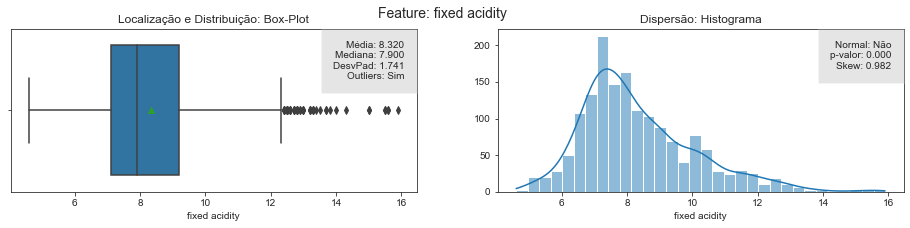

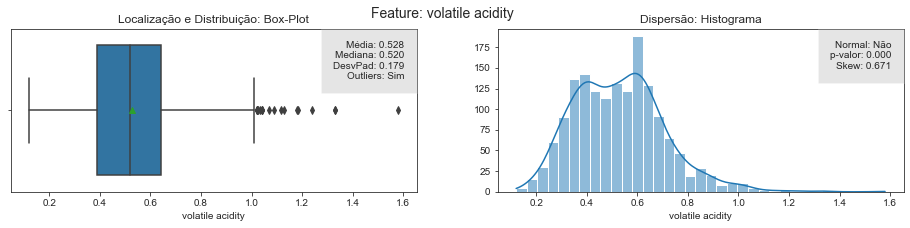

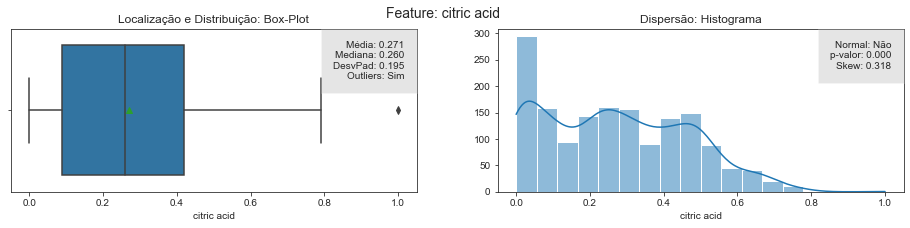

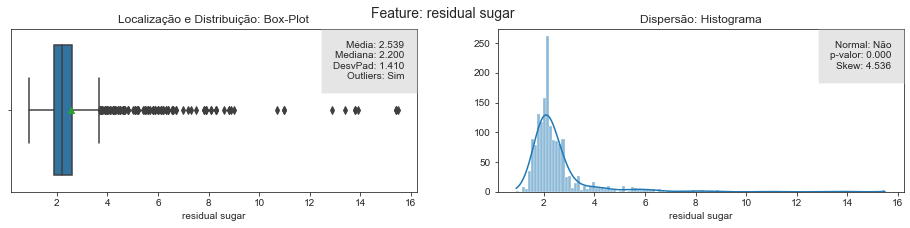

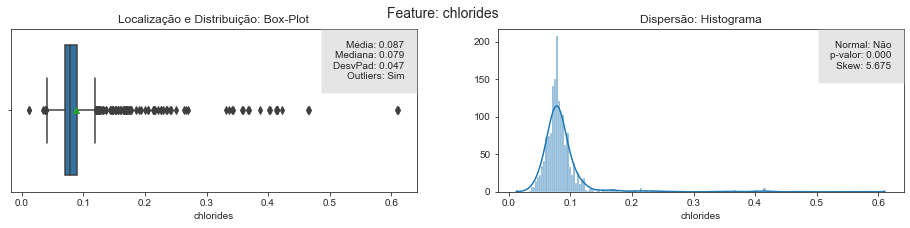

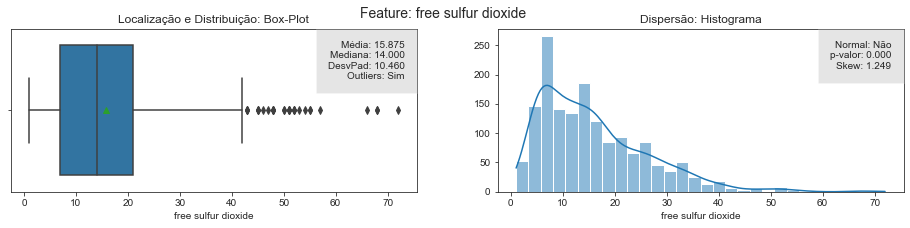

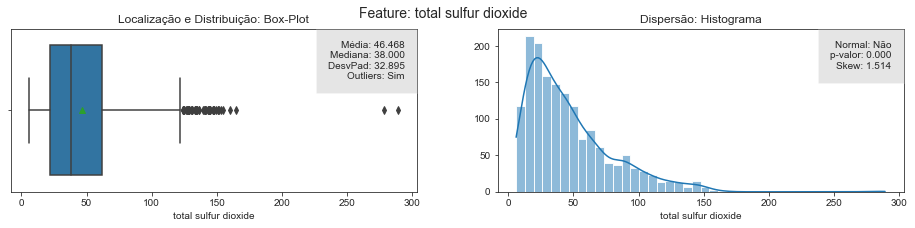

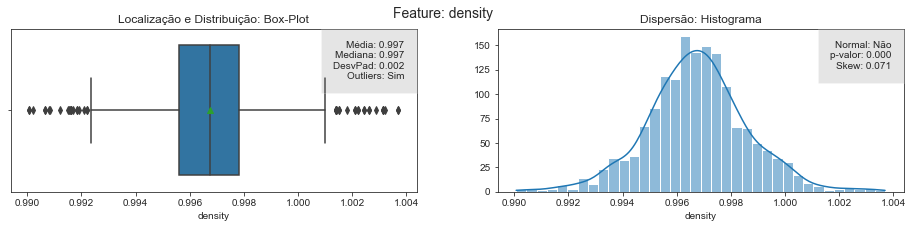

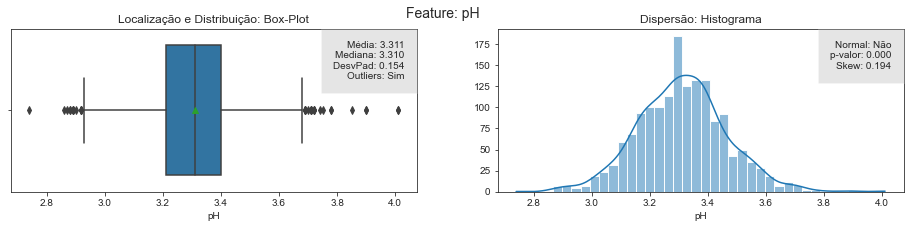

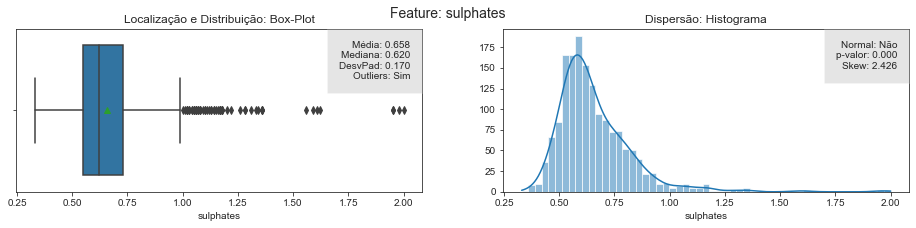

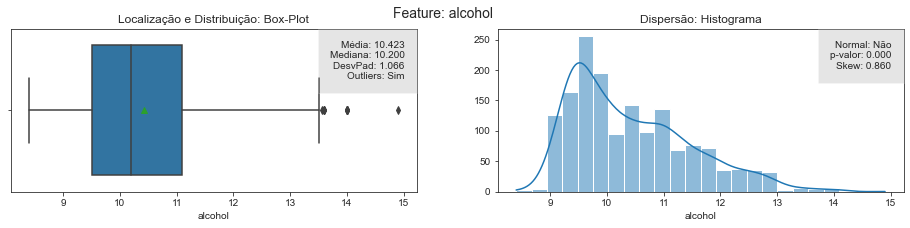

In [7]:
explore_features(df_red, features)

Pontos de atenção:

- Todas as *features* tem Outliers (destaque para "residual sugar") e não se aproximam de uma distribuição normal.
- Skewness especialmente alto em "fixed acidity", "citric acid", "chlorides", "total sulfur dioxide" e "sulphates" 
- A presença de outliers predomina em valores altos extremos, o que também contribui para um skewness positivo muito alto.

### 2.4 Explorando a Variável Dependente

Decidimos explorar sua distribuição com um gráfico de barras e checar seu valor esperado.

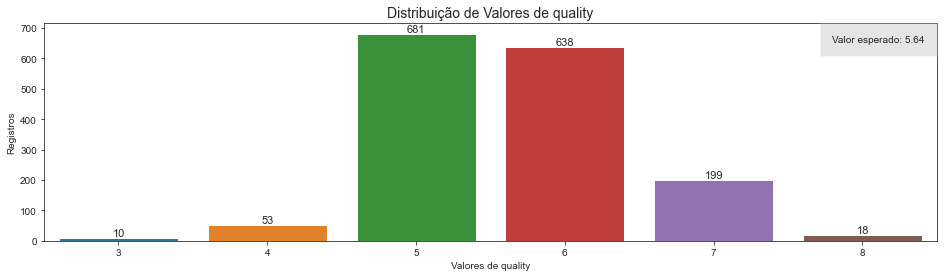

In [8]:
explore_target(df_red, target)

- Os dados estão desbalanceadas e muito concentrados em "5" e "6".
- Os valores extremos (qualidade muito baixa ou alta) são praticamente *outliers*.

### 2.5 Explorando as Correlações

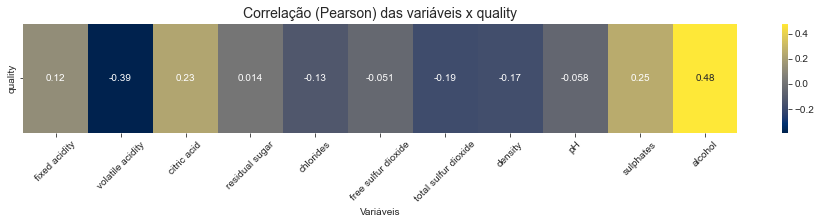

In [9]:
target_correlation(df_red, target)

Pontos de atenção:
- "alcohol" é a isoladamente a variável com maior impacto em "quality".
- "sulphates" e "citric acid" são as outras variáveis mais significativas.
- "volatile acidity" é a variável com correlação negativa mais forte.
- O restante das variáveis tem um coeficiente de correlação pouco expressivo.

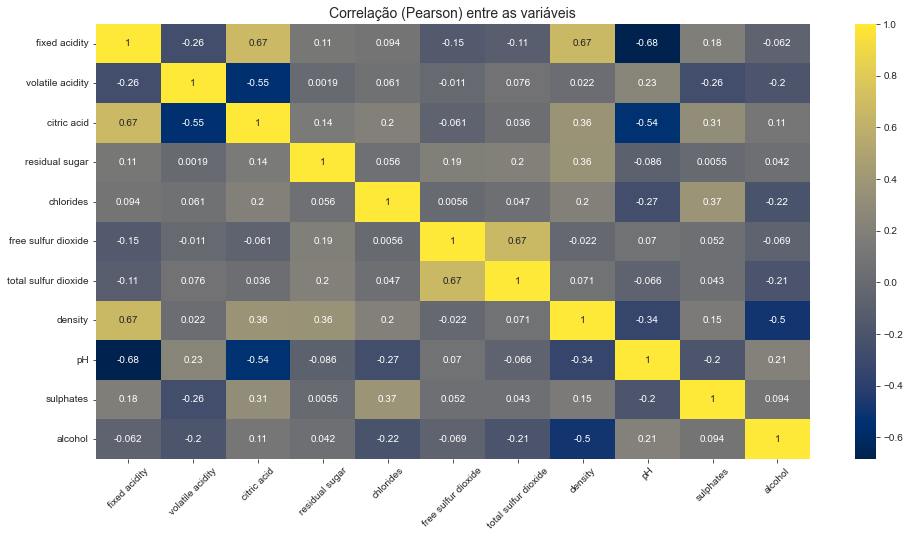

In [10]:
feature_correlation(df_red, target)

Pontos de ateção:
- O gráfico indica que pode haver multicolinearidade entre as variáveis, com diversos pontos com um coeficiente (em módulo) superior a 0.5.

## 3. Criando e Aplicando os Modelos (Regressão Linear e Logística) 🤖

In [11]:
def basic_linear_regression(df, features, target):
    """ """
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    R2 = metrics.r2_score(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = metrics.mean_absolute_error(y_test, y_pred)

    print('='*5+f'Regressão Linear'+'='*5,
          'Métricas'+'-'*18,
          f'R2: {R2:.4f}',
          f'RMSE: {RMSE:.4f}',
          f'MAE: {MAE:.4f}',
          f'MSE: {MSE:.4f}\n',
          sep='\n')


def basic_logistic_regression(df, features, target):
    """ """
    X = df[features]
    y = np.vectorize(lambda y: 0 if y <= 5 else 1)(df[target])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_score = model.decision_function(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision =  metrics.precision_score(y_test, y_pred)
    recall =  metrics.recall_score(y_test, y_pred)
    f1 =  metrics.f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_score)

    precisions, recalls, thresholds_pr = metrics.precision_recall_curve(y_test, y_score)
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_test, y_score)

    print('='*3+f'Regressão Logística'+'='*4,
          'Métricas'+'-'*18,
          f'Acurácia: {accuracy:.4f}',
          f'Precisão: {precision:.4f}',
          f'Revocação: {recall:.4f}',
          f'F1: {f1:.4f}',
          f'Área sob ROC: {roc_auc:.4f}',
          sep='\n')
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
    fig.suptitle(f'Visualização da Regressão Logística', fontsize=14)
    
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, ax=ax[0,0])
    ax[0,0].set_title('Matriz de Confusão')
    ax[0,1].plot(thresholds_pr, precisions[:-1], 'b--', label='Precision')
    ax[0,1].plot(thresholds_pr, recalls[:-1], 'g--', label='Recall')
    ax[0,1].set_title('Precisão e Revocação')
    metrics.PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax[1,0])
    ax[1,0].set_title('Curva PR')
    metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1,1])
    ax[1,1].set_title('Curva ROC')

    fig.tight_layout()
    plt.show()

=====Regressão Linear=====
Métricas------------------
R2: 0.4032
RMSE: 0.6245
MAE: 0.5035
MSE: 0.3900

===Regressão Logística====
Métricas------------------
Acurácia: 0.7406
Precisão: 0.7927
Revocação: 0.7263
F1: 0.7580
Área sob ROC: 0.8142


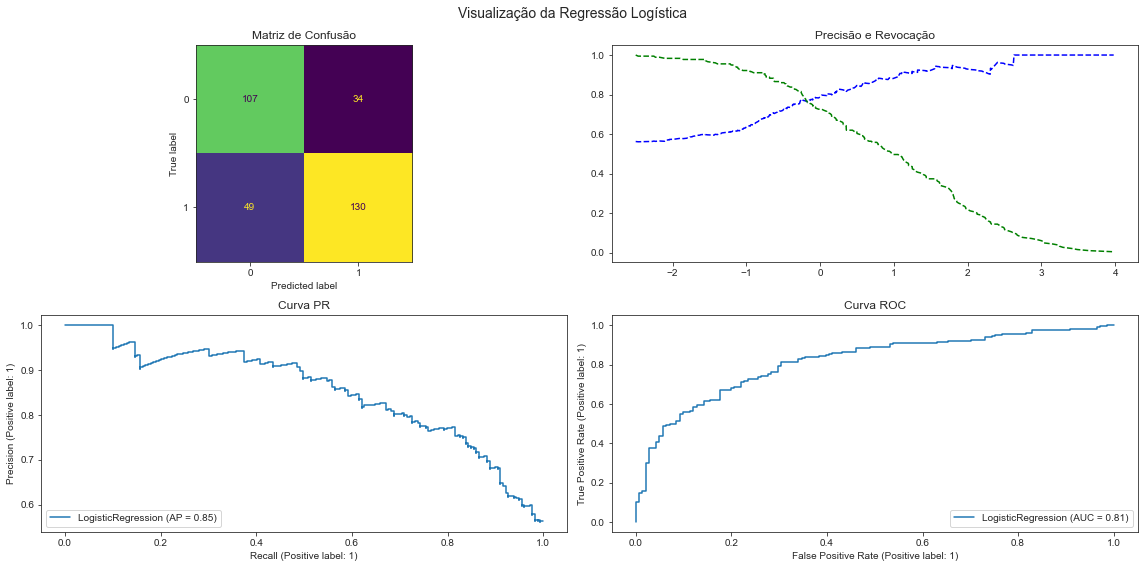

In [12]:
basic_linear_regression(df_red, features, target)
basic_logistic_regression(df_red, features, target)

## 4. Otimizando os Modelos 🔧

### 4.1 EDA: Insights & Ações :

1. Os Outliers podem ser tratados. Contudo, é possível que isso agrave ainda mais o desbalanceamento da variável resposta.
2. Pode-se manipular os dados para normalização das variáveis.
3. Nas variáveis onde o Skewness é muito alto, pode-se transformar os dados. Isso ajudaria a reduzir os impactos dos outliers e a deixar as variáveis mais próximas de uma distribuição normal.
4. É possível que nem todas as variáveis sejam significativas para os modelos.
5. Há indicação de multicolinearidade.
6. A variável resposta é do tipo discreta. Como os modelos apontam para dados contínuos, há um erro inerente a ser considerado.
7. A alta presença de valores duplicados pode influenciar nas predições do modelo.

### 4.1 Parâmetros: Insights & Ações :

1. Estratificar os dados em "y" (target).
2. Usar um método de *Standardization* ou *Regularização* no modelo. Escolhemos o **StandardScaler** para a Regressão Linear e o **MinMaxScaler** para a Regressão Logística.
3. Alterar thresholds (Regressão Logística). Como não há um contexto de negócio a ser levado em consideração, buscamos otimizar o as métricas de forma balanceada - sem algum trade-off de muito impacto. Nesse caso, decidimos escolher o threshold que maximizasse a relação $FPR+TPR-1$.
4. Vamos aplicar um *feature selection* na Regressão Logística, escolhendo um número K de variáveis rankeado pelo coeficiente R (Pearson) entre a variável e o *target* que otimize as métricas do modelo.

In [13]:
def transform_to_log(df, features, target, threshold=1):
    """ """
    columns_to_transform = df.skew()[df.skew() > threshold].index.to_list()
    
    # Checking for infinite values on transformation
    for column in columns_to_transform:
        if np.isinf(df[column].apply(np.log)).any():
            columns_to_transform.remove(column) # Do not transform the column
    df[columns_to_transform] = df[columns_to_transform].apply(np.log)
    return df

In [14]:
df_red = transform_to_log(df_red, features, target)

In [15]:
def optimized_linear_regression(df, features, target):
    """ """
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    R2 = metrics.r2_score(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = metrics.mean_absolute_error(y_test, y_pred)

    print('='*5+f'Regressão Linear'+'='*5,
          'Métricas'+'-'*18,
          f'R2: {R2:.4f}',
          f'RMSE: {RMSE:.4f}',
          f'MAE: {MAE:.4f}',
          f'MSE: {MSE:.4f}\n',
          sep='\n')


def optimized_logistic_regression(df, features, target):
    """ """
    X = df[features]
    y = np.vectorize(lambda y: 0 if y <= 5 else 1)(df[target])
    
    feature_selection = SelectKBest(score_func=f_regression, k=8)
    X = feature_selection.fit_transform(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    y_score = model.predict_proba(X_test)[:,1]
    
    precisions, recalls, thresholds_pr = metrics.precision_recall_curve(y_test, y_score)
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_test, y_score)
    optimized_thresold = thresholds_roc[np.argmin(np.abs(fpr+tpr-1))]
    
    y_pred = np.where(model.predict_proba(X_test)[:,1] > optimized_thresold, 1, 0)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision =  metrics.precision_score(y_test, y_pred)
    recall =  metrics.recall_score(y_test, y_pred)
    f1 =  metrics.f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_score)

    print('='*3+f'Regressão Logística'+'='*4,
          'Métricas'+'-'*18,
          f'Acurácia: {accuracy:.4f}',
          f'Precisão: {precision:.4f}',
          f'Revocação: {recall:.4f}',
          f'F1: {f1:.4f}',
          f'Área sob ROC: {roc_auc:.4f}',
          sep='\n')
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
    fig.suptitle(f'Visualização da Regressão Logística', fontsize=14)
    
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, ax=ax[0,0])
    ax[0,0].set_title('Matriz de Confusão')
    ax[0,1].plot(thresholds_pr, precisions[:-1], 'b--', label='Precision')
    ax[0,1].plot(thresholds_pr, recalls[:-1], 'g--', label='Recall')
    ax[0,1].set_title('Precisão e Revocação')
    metrics.PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax[1,0])
    ax[1,0].set_title('Curva PR')
    metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1,1])
    ax[1,1].set_title('Curva ROC')

    fig.tight_layout()
    plt.show()

## 5. Aplicando os Modelos (Regressão Linear e Logística) 🤖

=====Regressão Linear=====
Métricas------------------
R2: 0.4153
RMSE: 0.6182
MAE: 0.4970
MSE: 0.3821

===Regressão Logística====
Métricas------------------
Acurácia: 0.7469
Precisão: 0.7917
Revocação: 0.7430
F1: 0.7666
Área sob ROC: 0.8202


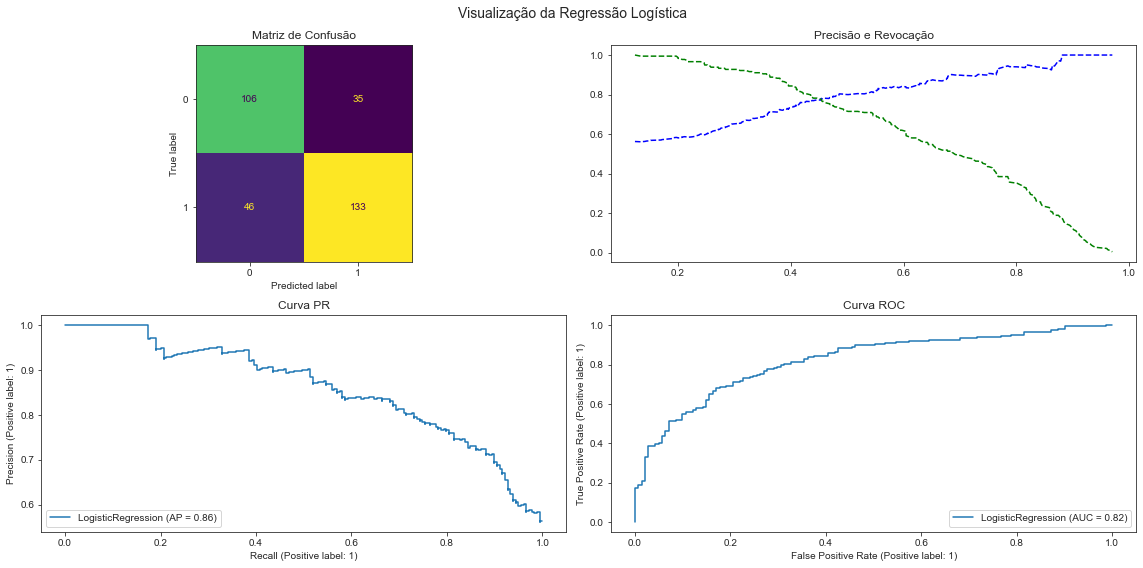

In [16]:
optimized_linear_regression(df_red, features, target)
optimized_logistic_regression(df_red, features, target)

## 6. Discussão 💬

Transformar os dados das variáveis com skewness alto para a escala logarítmica, selecionar *features* e escolher um threshold diferente gerou ganhos marginais em ambos os modelos.

### Regressão Linear

Apresentou um coeficiente $Rˆ2$ baixo. Em contraponto, suas três métricas de erro também tem valores baixos. Apesar de testar algumas otimizações, não houve melhoria significativa. 

Acreditamos que esse modelo foi especialmente impactado pelo formato e distribuição dos dados do *target* - que gerava um erro inerente às previsões. 

Também é importante ressaltar que nenhuma variável apresentou um coeficiente de correlação alto com o *target* (visto na EDA).

### Regressão Logística
A Regressão Logística teve suas métricas balanceadas - isso é bom, dado o nosso objetivo de escolha do threshold.

Todas as métricas do modelo estão acima dos 74% e a área sob a curva ROC é superior a 82%. É um modelo confiável

### Melhorias
- Apesar dos esforços de otimização, os modelos não obtiveram muita melhoria. Isso nos levar a crer que outros modelos podem se encaixar melhor aos dados e produzir melhores métricas.
- Com o desbalanceamento dos dados do *target*, a validação cruzada das métricas poderia ser uma melhor escolha.
- Ainda sobre o desbalanceamento dos dados, poderia-se aplicar técnicas de Oversampling ou Undersampling.
- Normalizar todas as *features* poderia produzir melhores resultados.
- Aplicar o log em todas as variáveis ou testar outras técnicas para lidar com skewness.
- Observar a kurtosis na EDA.
- Observar a dispersão das variáveis estratificadas (em cor) pelo target poderia dar mais insights sobre a a relação com o target (ou até encontrar features polinomiais).
